In [1]:
import pandas as pd
from pathlib import Path
import joblib
from train.variables import variables
from train.calibration import SigmoidCalibrator
from train import calibration
from sklearn.preprocessing import MinMaxScaler, normalize

In [2]:
def parseName(name):
    vecName = name.split('.')[0].split('/')[-1].split('_')
    model = vecName[0]
    version = vecName[1]
    weight = name.split('.')[0].split('/')[-3]
    test = vecName[2]
    return model, version, weight, test

def read_directory(dir):
    metrix = []
    for file in dir.glob('fit/**/*.csv'):
        metrix2 = pd.read_csv(file)
        model, version, weight, test = parseName(file.as_posix())
        metrix2['name'] = model
        metrix2['version'] = version
        metrix2['weight'] = weight
        metrix2['test'] = test
        metrix.append(metrix2)
    for file in dir.glob('fit/**/*.csv'):
        metrix2 = pd.read_csv(file)
        model, version, weight, test = parseName(file.as_posix())
        metrix2['name'] = model
        metrix2['version'] = version
        metrix2['weight'] = weight
        metrix2['test'] = test
        metrix.append(metrix2)
    metrix = pd.concat(metrix).reset_index(drop=True)
    metrix['dataset_version'] = dir.as_posix()
    return metrix

In [3]:
datasets_version = ['GMClustering']

metrix = []

for dataset_version in datasets_version:
    metrix.append(read_directory(Path(dataset_version)))

metrix = pd.concat(metrix).sort_values(['name', 'version', 'weight'])

In [4]:
metrix = metrix[metrix['name'].isin(['gat3', 'gat3WithoutSocio', 'gat3WithoutHisto', 'gat3WithoutMeteo', 'gat3WithoutTopo'])].reset_index(drop=True)
metrix = metrix[metrix['version'].isin(['test2023'])]

In [5]:
metrix = metrix.loc[::2]

In [6]:
metrix['ece'] = metrix['ece'].apply(lambda x : float(x.split(' ')[1][:-1]))

In [7]:
metrix[metrix['name'] == 'gat3'][['ece', 'logloss', 'firelogloss']]

,ece,logloss,firelogloss
6,3.878234,0.502304,0.992291


In [8]:
metrix

,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,ECE,dataset_version
6,0.502304,0.992291,0.085040,0.007232,3.878234,gat3,test2023,calibratedWeights,metrix,NaN,GMClustering
22,0.585528,0.857708,0.188108,0.035385,11.774624,gat3WithoutHisto,test2023,calibratedWeights,metrix,NaN,GMClustering
38,0.488632,0.837442,0.070452,0.004963,4.339821,gat3WithoutMeteo,test2023,calibratedWeights,metrix,NaN,GMClustering
54,0.506346,1.014226,0.095697,0.009158,4.005507,gat3WithoutSocio,test2023,calibratedWeights,metrix,NaN,GMClustering
70,0.520507,0.923314,0.096271,0.009268,4.615506,gat3WithoutTopo,test2023,calibratedWeights,metrix,NaN,GMClustering


In [162]:
"""metrix['ece'] = normalize([metrix['ece'].values], norm='l2')[0]
metrix['logloss'] = normalize([metrix['logloss'].values], norm='l2')[0]
metrix['firelogloss'] = normalize([metrix['firelogloss'].values], norm='l2')[0]"""

#metrix[['ece', 'logloss', 'firelogloss']] = MinMaxScaler((0.1,0.9)).fit_transform(metrix[['ece', 'logloss', 'firelogloss']].values)

metrix['VariationECE'] = abs(metrix['ece'] - metrix[metrix['name'] == 'gat3']['ece'].values[0])
metrix['Variationlogloss'] = abs(metrix['logloss'] - metrix[metrix['name'] == 'gat3']['logloss'].values[0])
metrix['Variationfirelogloss'] = abs(metrix['firelogloss'] - metrix[metrix['name'] == 'gat3']['firelogloss'].values[0])

metrix[['VariationECE', 'Variationlogloss', 'Variationfirelogloss']] = MinMaxScaler((0.1,0.9)).fit_transform(metrix[['VariationECE', 'Variationlogloss', 'Variationfirelogloss']].values)

In [153]:
metrix

,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,ECE,dataset_version,VariationECE,Variationlogloss,Variationfirelogloss
name,,,,,,,,,,,,,,
gat3,0.208736,0.900000,0.085040,0.007232,0.163496,gat3,test2023,calibratedWeights,metrix,NaN,GMClustering,0.000000,0.000000,0.000000
gat3WithoutHisto,0.900000,0.329373,0.188108,0.035385,0.900000,gat3WithoutHisto,test2023,calibratedWeights,metrix,NaN,GMClustering,0.736504,0.691264,0.570627
gat3WithoutMeteo,0.100000,0.539778,0.068981,0.004758,0.100000,gat3WithoutMeteo,test2023,calibratedWeights,metrix,NaN,GMClustering,0.063496,0.108736,0.360222
gat3WithoutTopo,0.305854,0.100000,0.112297,0.012611,0.341212,gat3WithoutTopo,test2023,calibratedWeights,metrix,NaN,GMClustering,0.177716,0.097118,0.800000


Text(0, 0.5, 'Value')

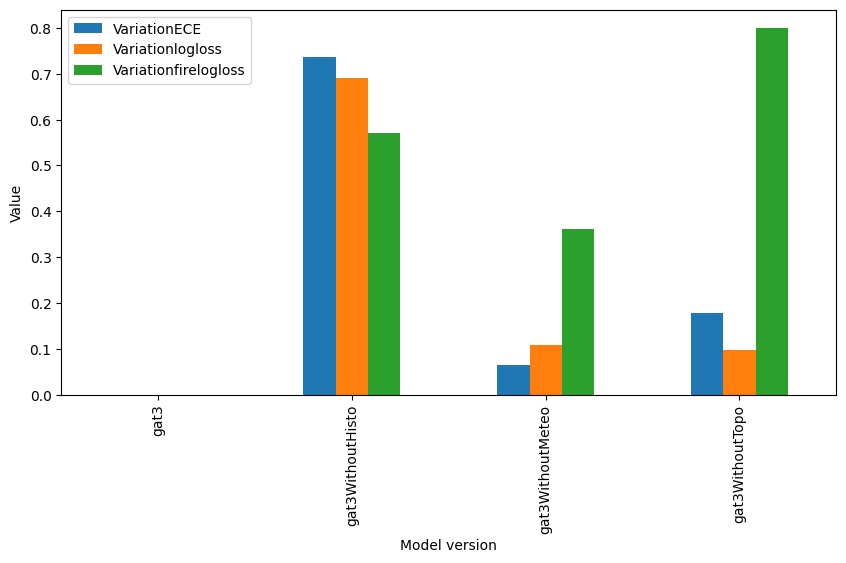

In [154]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10,5))

metrix.index = metrix.name
metrix[['VariationECE', 'Variationlogloss', 'Variationfirelogloss']].plot.bar(ax=ax)
ax.set_xlabel('Model version')
ax.set_ylabel('Value')

In [7]:
testMetrix = metrix[metrix['test'] == 'testSet']
test2023Metrix = metrix[metrix['test'] == 'test2023']

testFireMetrix = metrix[metrix['test'] == 'testSetFire']
test2023FireMetrix = metrix[metrix['test'] == 'test2023Fire']

summer = metrix[metrix['test'] == 'test2023Summer']
winter = metrix[metrix['test'] == 'test2023Winter']

In [8]:
import numpy as np

def expected_calibration_error(true_labels_series, samples, bins=5):
    true_labels = true_labels_series.values
    samples = samples.reshape(-1)
    bin_count, bin_edges = np.histogram(samples, bins = 1)
    n_bins = len(bin_count)
    # uniform binning approach with M number of bins
    bin_boundaries = bin_edges
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences = samples

    # get a boolean list of correct/false predictions
    accuracies = true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return n_bins, ece[0] * 100

In [9]:
display(testMetrix[testMetrix['logloss'] == testMetrix['logloss'].min()])
display(testFireMetrix[testFireMetrix['logloss'] == testFireMetrix['logloss'].min()])
display(test2023Metrix[test2023Metrix['logloss'] == test2023Metrix['logloss'].min()])
display(test2023FireMetrix[test2023FireMetrix['logloss'] == test2023FireMetrix['logloss'].min()])

,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


In [10]:
test2023Metrix.sort_values(['ece'])

,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


In [11]:
test2023FireMetrix.sort_values(['logloss'])

,logloss,firelogloss,rmse,mse,ece,name,version,weight,test,f1score,ECE,dataset_version


In [12]:
import numpy as np

dataset_version = 'GMClustering'
subDir = ''
path = Path(dataset_version)
path = path / subDir

dataset = pd.read_csv(path / 'test_2023.csv')
dataset2023 = pd.read_csv(path / 'dataset_2023_calibrated.csv')

departmentPrediction = False

ids = np.arange(0, 10)

if departmentPrediction:
    variablesToAdd = variables.copy()
    newVariables = ['month',
    'dayofyear', 'dayofweek',
    'bankHolidays', 'bankHolidaysEve', 'bankHolidaysEveEve',
    'holidays', 'holidaysEve', 'holidaysEveEve', 'holidaysLastDay', 'holidaysLastLastDay']

    for var in newVariables:
        variablesToAdd.remove(var)

    for id in ids:
        datasetCluster = dataset[dataset['cluster'] == id]
        columns = [col + '_' + str(id) for col in variablesToAdd]
        
        newVariables += columns

    variables = newVariables

dataset2023.sort_values('creneau', inplace=True)
dataset2023.dropna(subset=variables, inplace=True)
dataset2023.reset_index(drop=True, inplace=True)

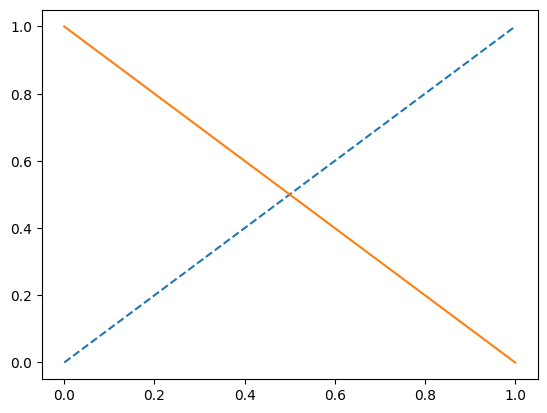

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

dataset2023['pred'] = 1 - dataset2023['isNATURELSFire']
expected_calibration_error(dataset2023['isNATURELSFire'], dataset2023['pred'].values)

hist, bin_edge = np.histogram(dataset2023['pred'] , bins='auto')
n_bins = len(bin_edge)
y_means, proba_means = calibration_curve(dataset2023['isNATURELSFire'], dataset2023['pred'] , n_bins=n_bins, strategy='quantile')
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)

In [14]:
dataset2023[['pred', 'isNATURELSFire']]

,pred,isNATURELSFire
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
40151,1.0,0.0
40152,1.0,0.0
40153,1.0,0.0
40154,1.0,0.0


In [15]:
dataset2023 = dataset2023[(dataset2023['creneau'] >= '2023-01-01') | (dataset2023['departement'] == 69)]

In [16]:
subDir = 'fit'
model = 'xgboost'
calibrate = ''
weight = 'calibratedWeights'

binary = False
quantile = False

path = Path(dataset_version)
path = path / subDir / weight / model
name = model+calibrate+'.joblib'
model = joblib.load(path/name)

In [17]:
from scipy.signal import savgol_filter
if subDir == 'binary':
    dataset['predictedProba_mid'] = model.predict_proba(dataset[variables])[:,1]
    dataset2023['predictedProba_mid'] = model.predict_proba(dataset2023[variables])[:,1]
elif subDir == 'multibinary':
    dataset['predictedProba_mid'] = model.predict_proba(dataset[variables])[:,1]
    dataset2023['predictedProba_mid'] = model.predict_proba(dataset2023[variables])[:,1]
elif quantile:
    dataset['predictedProba_low'] = model.predict(dataset[variables])[:,0]
    dataset2023['predictedProba_low'] = model.predict(dataset2023[variables])[:,0]

    dataset['predictedProba_mid'] = model.predict(dataset[variables])[:,1]
    dataset2023['predictedProba_mid'] = model.predict(dataset2023[variables])[:,1]

    dataset['predictedProba_high'] = model.predict(dataset[variables])[:,2]
    dataset2023['predictedProba_high'] = model.predict(dataset2023[variables])[:,2]
elif subDir == 'multiregression':
    pred = model.predict(dataset2023[variables])
    pred = np.moveaxis(pred, 0, 1)
    for i in range(11):
        dataset2023['predictedProba_mid'+str(i)] = pred[i]
else:
    #dataset['predictedProba_mid'] = model.predict(dataset[variables])
    dataset2023['predictedProba_mid'] = model.predict(dataset2023[variables])

In [18]:
"""from sklearn.metrics import log_loss
import numpy as np
sample_weight = dataset[dataset['isFire'] == 1]['weights_reg']
print(log_loss(dataset[dataset['isFire'] == 1]['isFire'], dataset[dataset['isFire'] == 1]['predictedProba_mid'], sample_weight=sample_weight, labels=(0,1)))
print(log_loss(dataset['isFire'], dataset['predictedProba_mid'], sample_weight=dataset['weights_reg'], labels=(0,1)))"""

"from sklearn.metrics import log_loss\nimport numpy as np\nsample_weight = dataset[dataset['isFire'] == 1]['weights_reg']\nprint(log_loss(dataset[dataset['isFire'] == 1]['isFire'], dataset[dataset['isFire'] == 1]['predictedProba_mid'], sample_weight=sample_weight, labels=(0,1)))\nprint(log_loss(dataset['isFire'], dataset['predictedProba_mid'], sample_weight=dataset['weights_reg'], labels=(0,1)))"

In [19]:
from sklearn.metrics import log_loss
import numpy as np
def my_log_loss(ytrue, ypred, sample_weights, pad):
    res = []
    leni = len(ypred)
    i = 0
    while i < leni:
        res.append(log_loss(ytrue[i:i + pad], ypred[i:i + pad], sample_weight=sample_weights[i:i+pad], labels=[0,1]))
        i += pad

    return np.array(res)

In [20]:
import matplotlib.pyplot as plt

In [21]:
def plot(dataset, type = 'fit', name =''):

    if type == 'multiregression':
        ra = 11

    clusterId = dataset.cluster.unique()

    if len(clusterId) > 1:

        fig, ax = plt.subplots(int(len(clusterId)), figsize = (20,20))
        
        for i, cID in enumerate(clusterId):
            dataset252_ = dataset[(dataset['cluster'] == cID)]
            dataset252_Fire = dataset252_[dataset252_['isNATURELSFire'] > 0]
            ax[i].set_ylim([0, 1])
            ax[i].scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaNATURELSFiretest_1.values, color='black', label='IsFire')
            ax[i].plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest_1.values, label='Calibrated Proba')
            if type == 'multiregression':
                for j in range(ra):
                    ax[i].plot(dataset252_.index.values, dataset252_['predictedProba_mid'+str(j)].values, label='Regression')
            else:
                ax[i].plot(dataset252_.index.values, dataset252_['predictedProba_mid'].values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_low.values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_high.values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_bin.values, label='Binary')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_bin_sigmoid.values, label='Sigmoid')
            #ax[i].fill_between(
            #    dataset252_.dayofyear.values, dataset252_.predictedProba_low.values, dataset252_.predictedProba_high.values, alpha=0.4, label="Predicted 90% interval"
            #)
            ax[i].set_ylabel('Probability')
            ax[i].set_xlabel('Day of year')
            
        plt.tight_layout()
        plt.legend()

    else:
        fig, ax = plt.subplots(1, figsize = (20,5))
        
        for i, cID in enumerate(clusterId):
            dataset252_ = dataset[(dataset['cluster'] == cID)]
            dataset252_Fire = dataset252_[dataset252_['isNATURELSFire'] > 0]
            ax.set_ylim([0, 1])
            ax.scatter(dataset252_Fire.index.values, dataset252_Fire.calibratedProbaNATURELSFiretest.values, color='black', label='IsNATURELSFire')
            ax.plot(dataset252_.index.values, dataset252_.calibratedProbaNATURELSFiretest.values, label='Calibrated Proba')
            ax.plot(dataset252_.index.values, dataset252_.predictedProba_mid.values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_low.values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_high.values, label='Regression')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_bin.values, label='Binary')
            #ax[i].plot(dataset252_.dayofyear.values, dataset252_.predictedProba_bin_sigmoid.values, label='Sigmoid')
            #ax[i].fill_between(
            #    dataset252_.dayofyear.values, dataset252_.predictedProba_low.values, dataset252_.predictedProba_high.values, alpha=0.4, label="Predicted 90% interval"
            #)
            ax.set_ylabel('Probability')
            ax.set_xlabel('Day of year')
            
        plt.tight_layout()
        plt.legend()
    output =  name + calibrate + '.png'
    plt.savefig(path/ output)

In [22]:
import numpy as np

Ain = np.arange(0,10)
rhone = np.arange(680,690)
Doubs = np.arange(200, 300)
Yvelines = np.arange(700,1000)

In [23]:
dataset2023.columns

Index(['creneau', 'cluster', 'temp_std_0', 'dwpt_std_0', 'rhum_std_0',
       'prcp_std_0', 'wdir_std_0', 'wspd_std_0', 'prec24h_std_0', 'dc_std_0',
       ...
       'calibratedProbaNATURELSFiretest_7',
       'calibratedClassNATURELSFiretest_7',
       'calibratedProbaNATURELSFiretest_8',
       'calibratedClassNATURELSFiretest_8',
       'calibratedProbaNATURELSFiretest_9',
       'calibratedClassNATURELSFiretest_9',
       'calibratedProbaNATURELSFiretest_10',
       'calibratedClassNATURELSFiretest_10', 'pred', 'predictedProba_mid'],
      dtype='object', length=984)

### Rhone

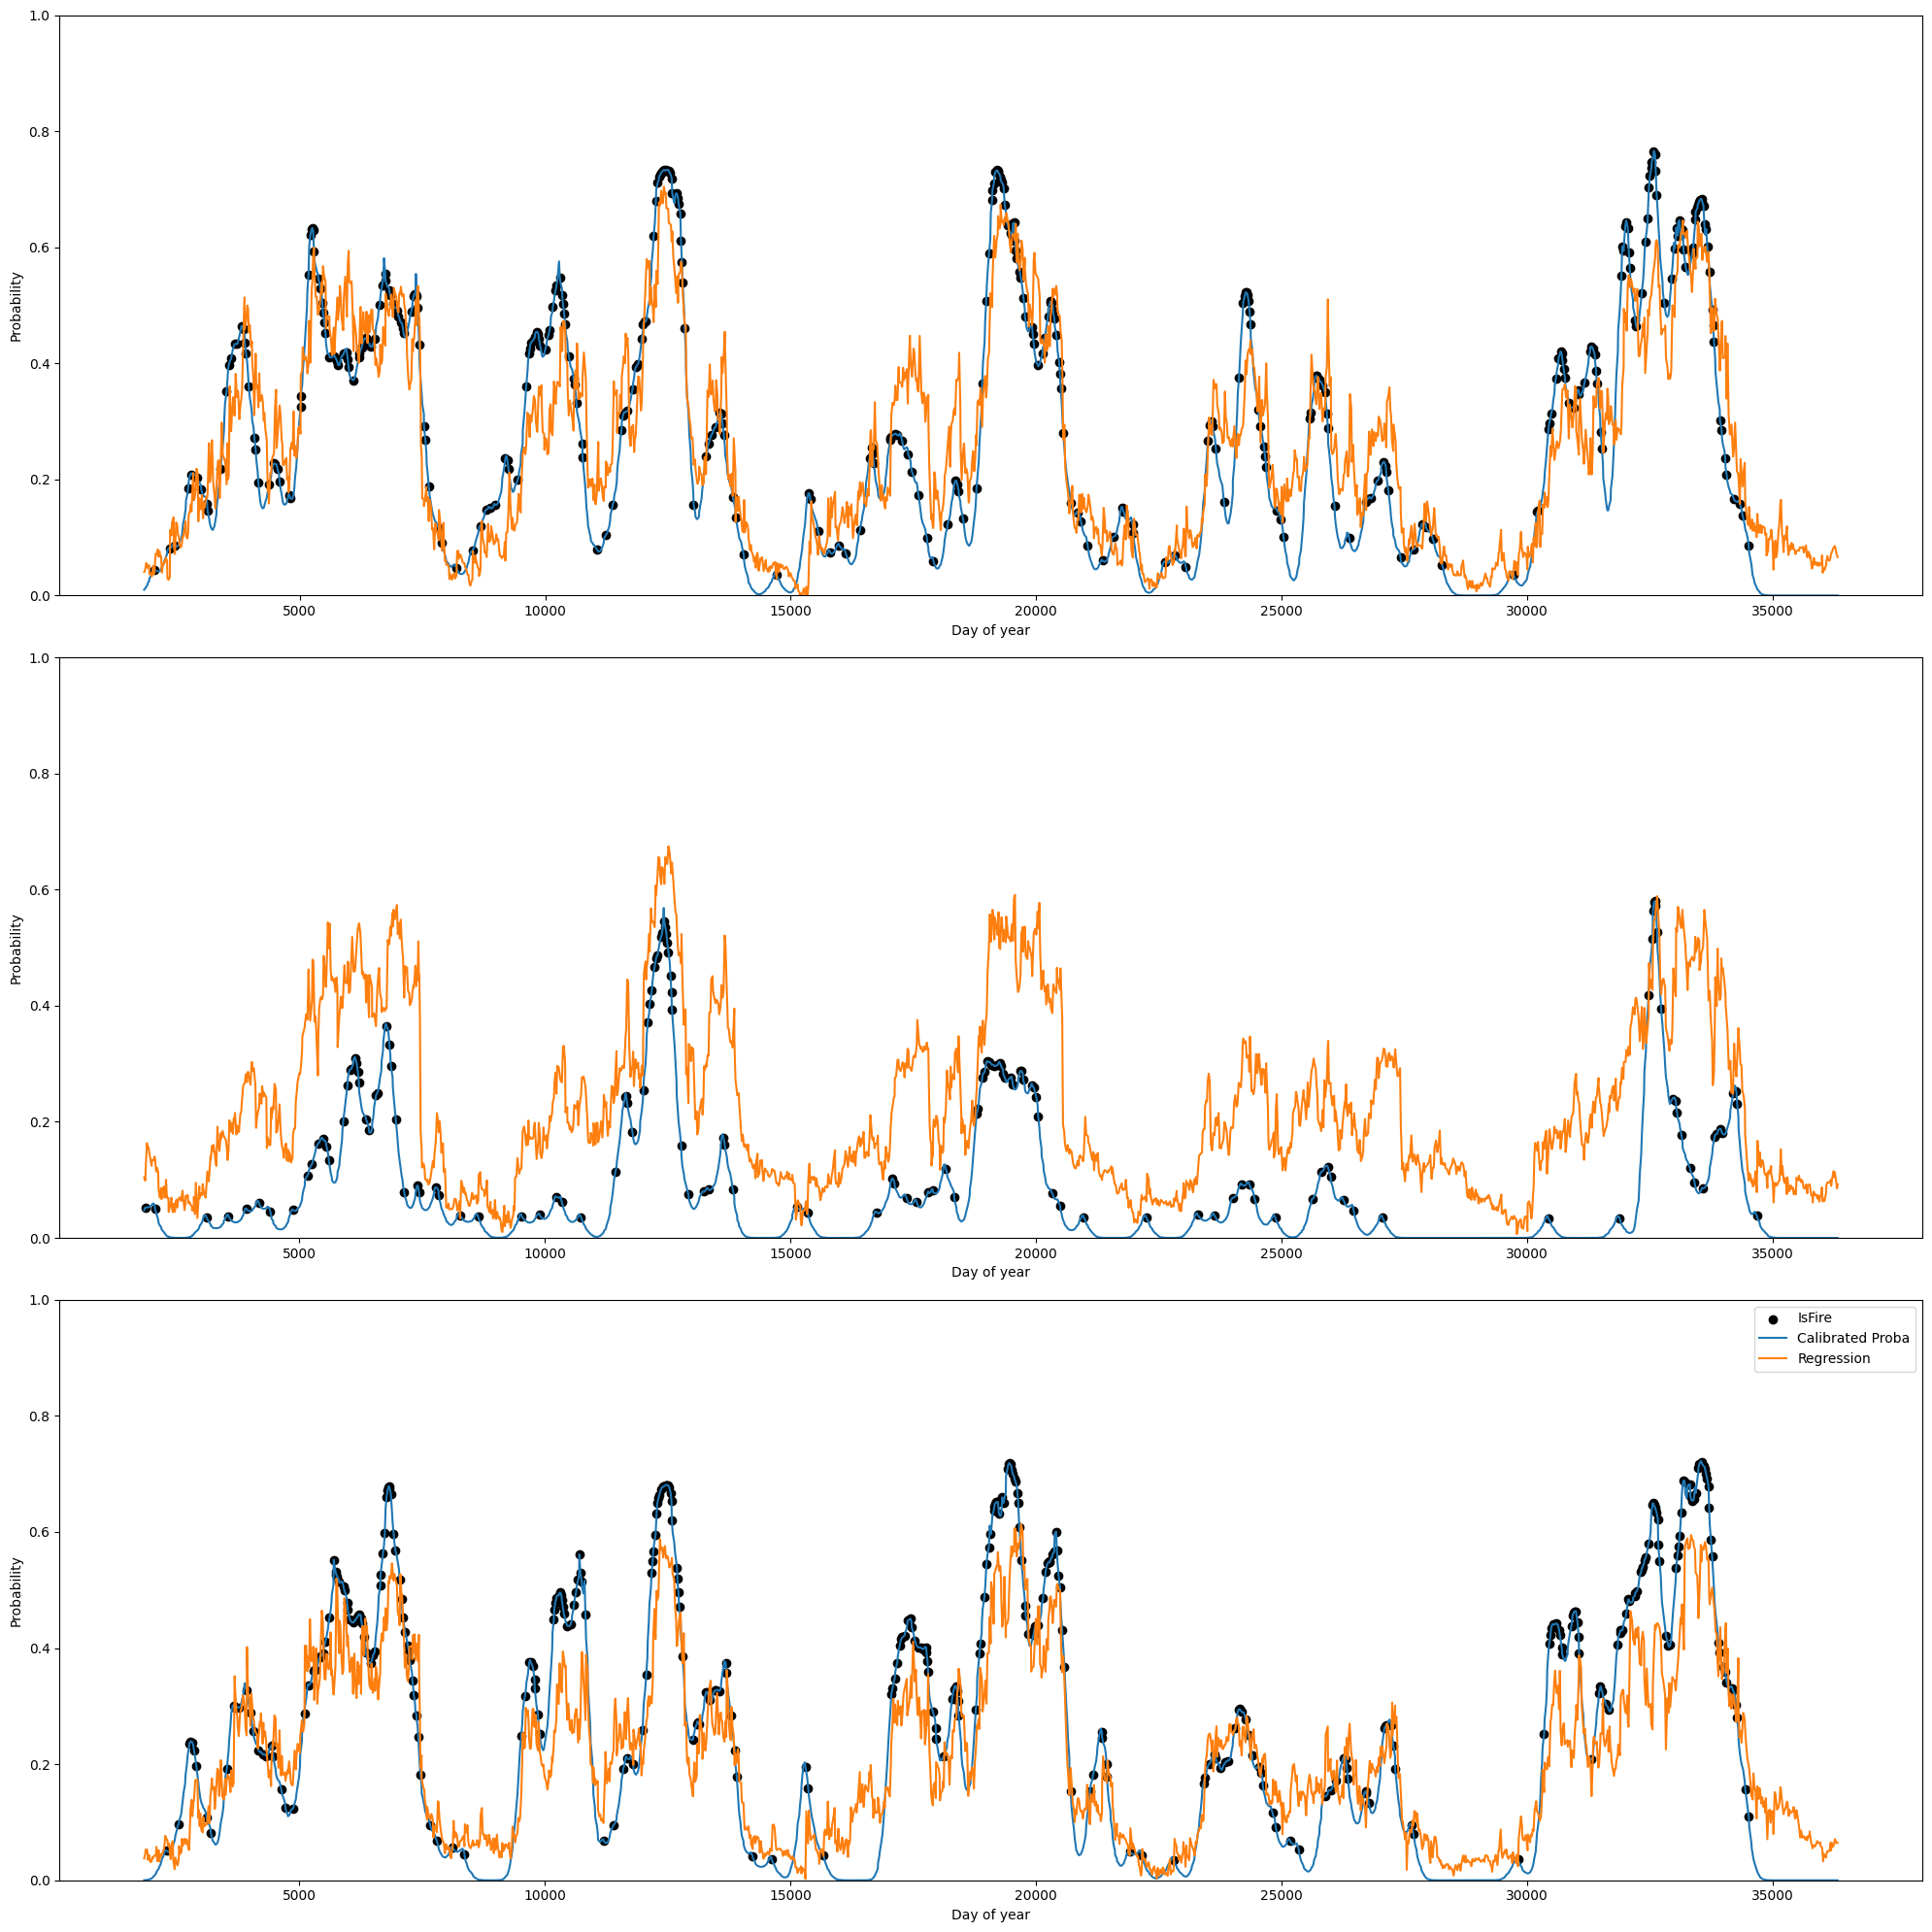

In [24]:
plot(dataset2023[dataset2023['cluster'].isin(rhone)], subDir, 'rhone')

### 2023

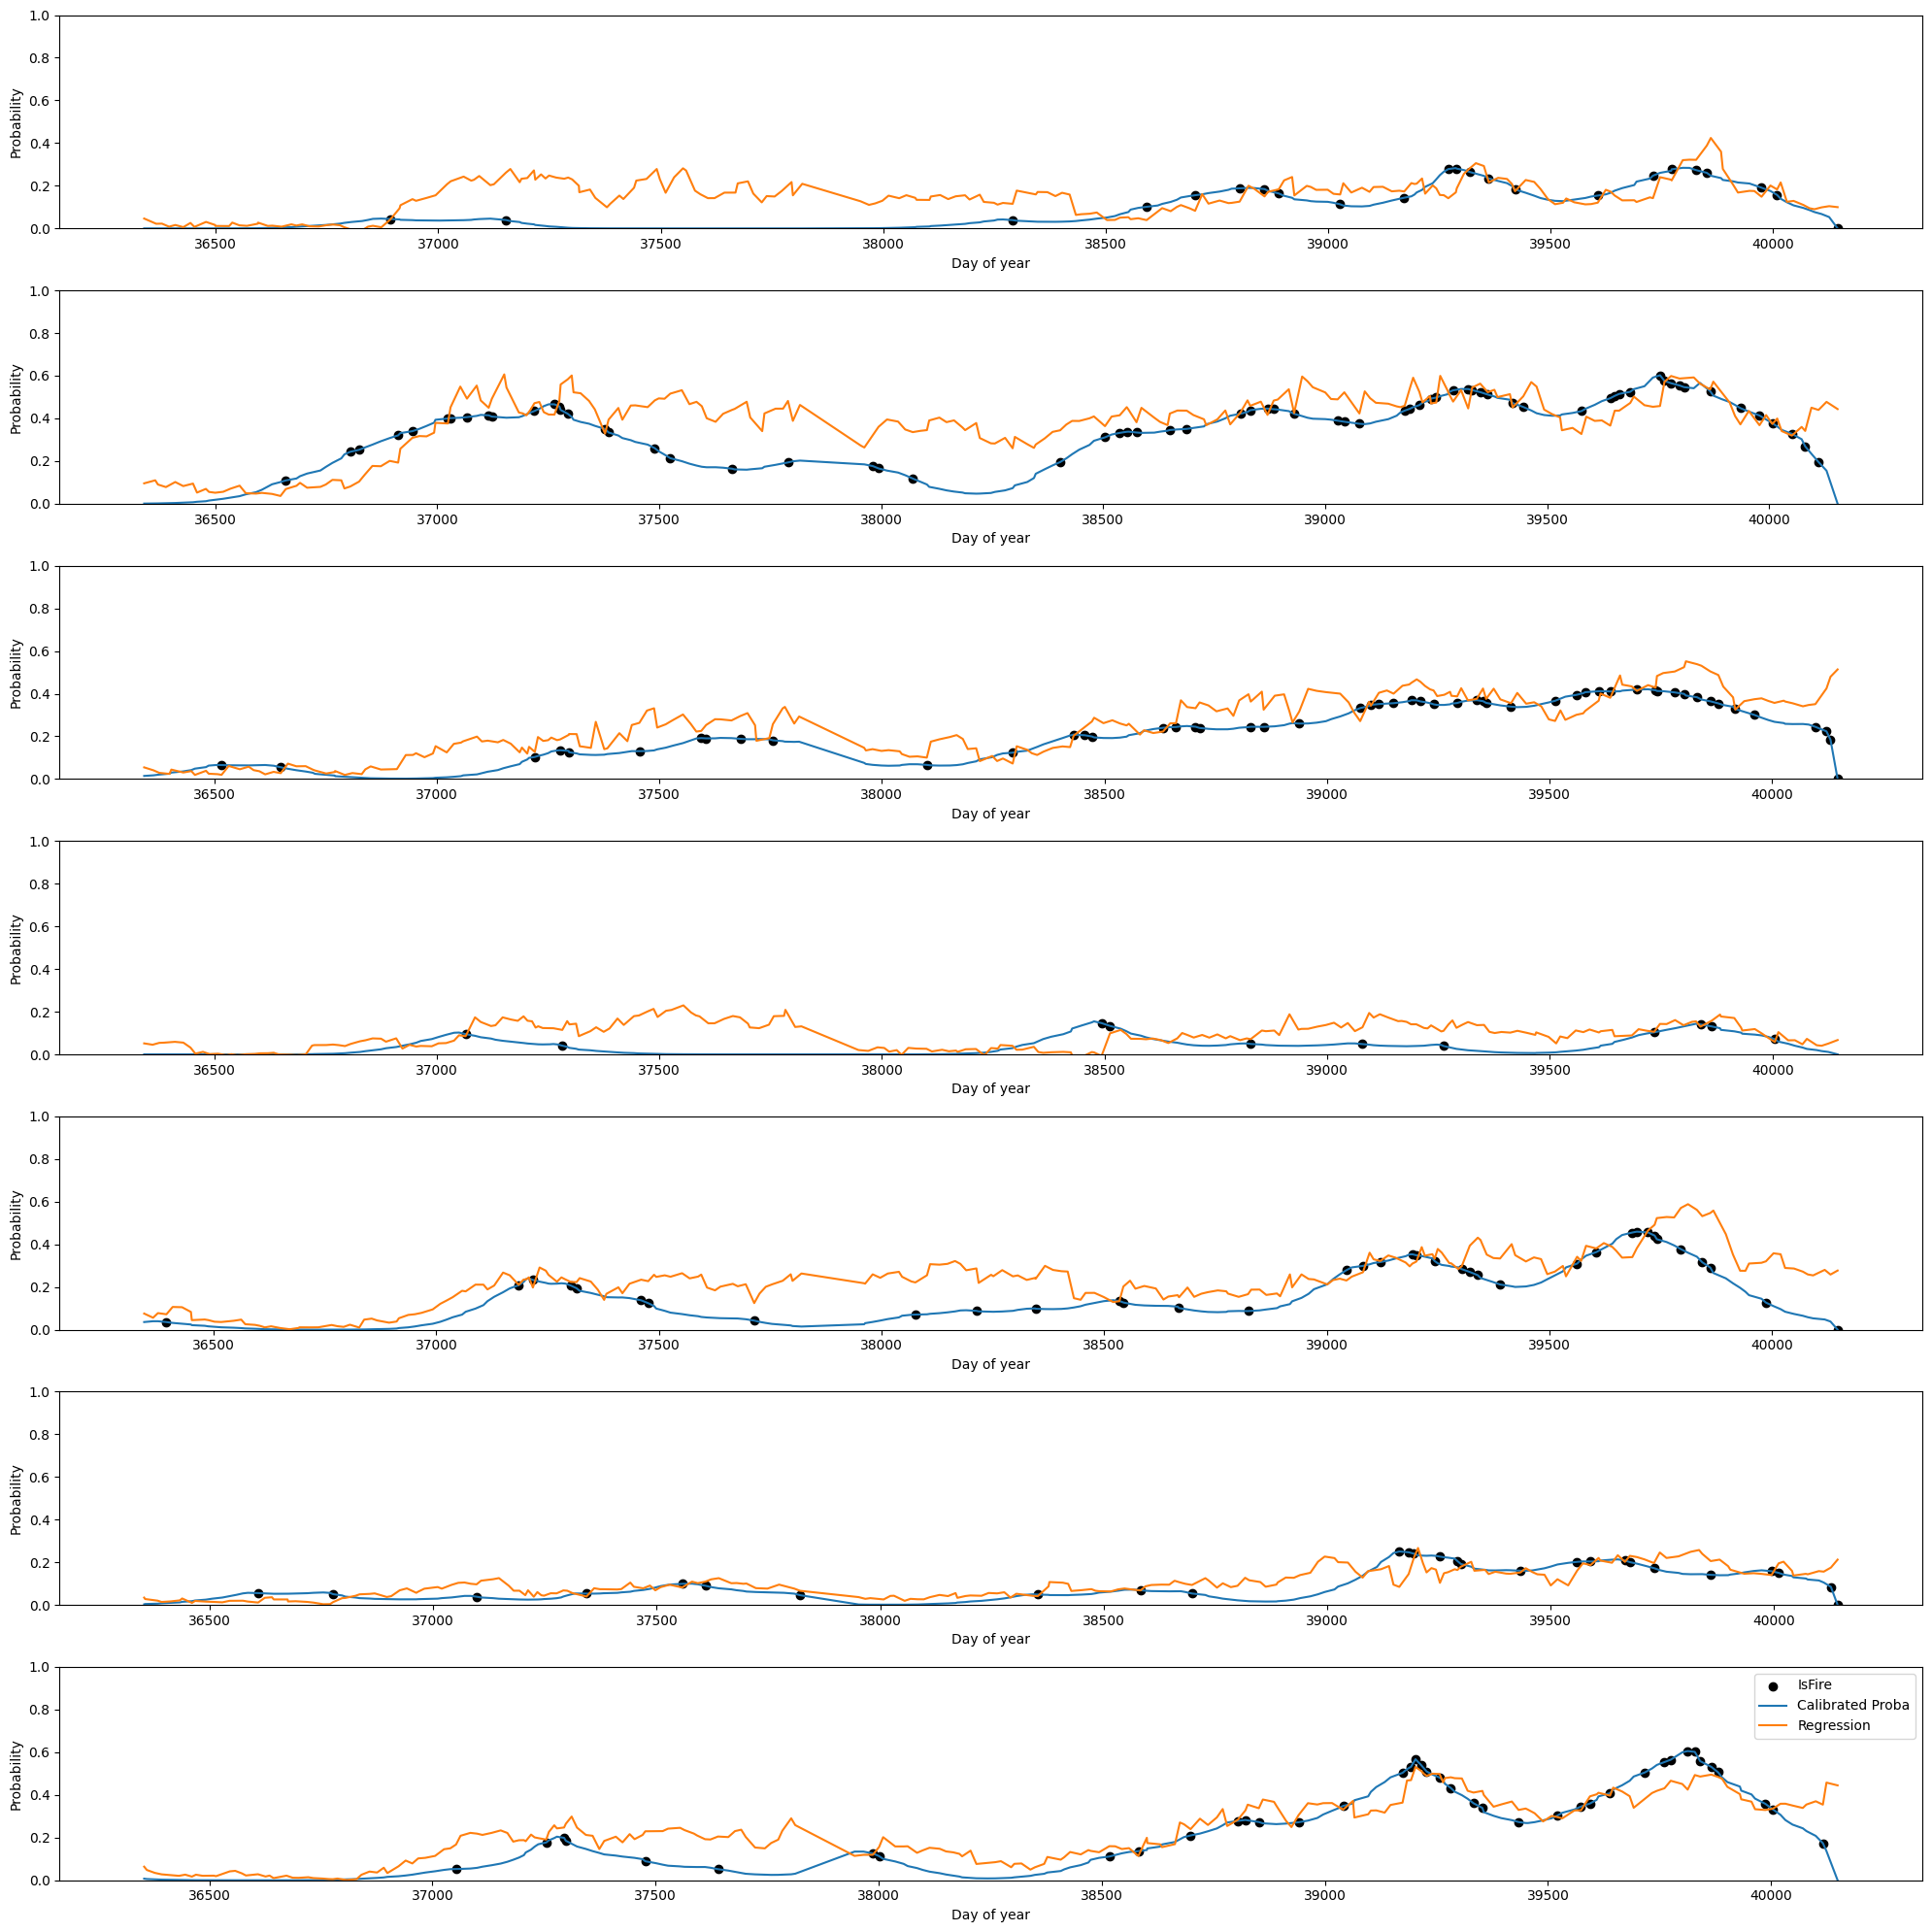

In [25]:
plot(dataset2023[dataset2023['cluster'].isin(Ain)], subDir, 'ain')

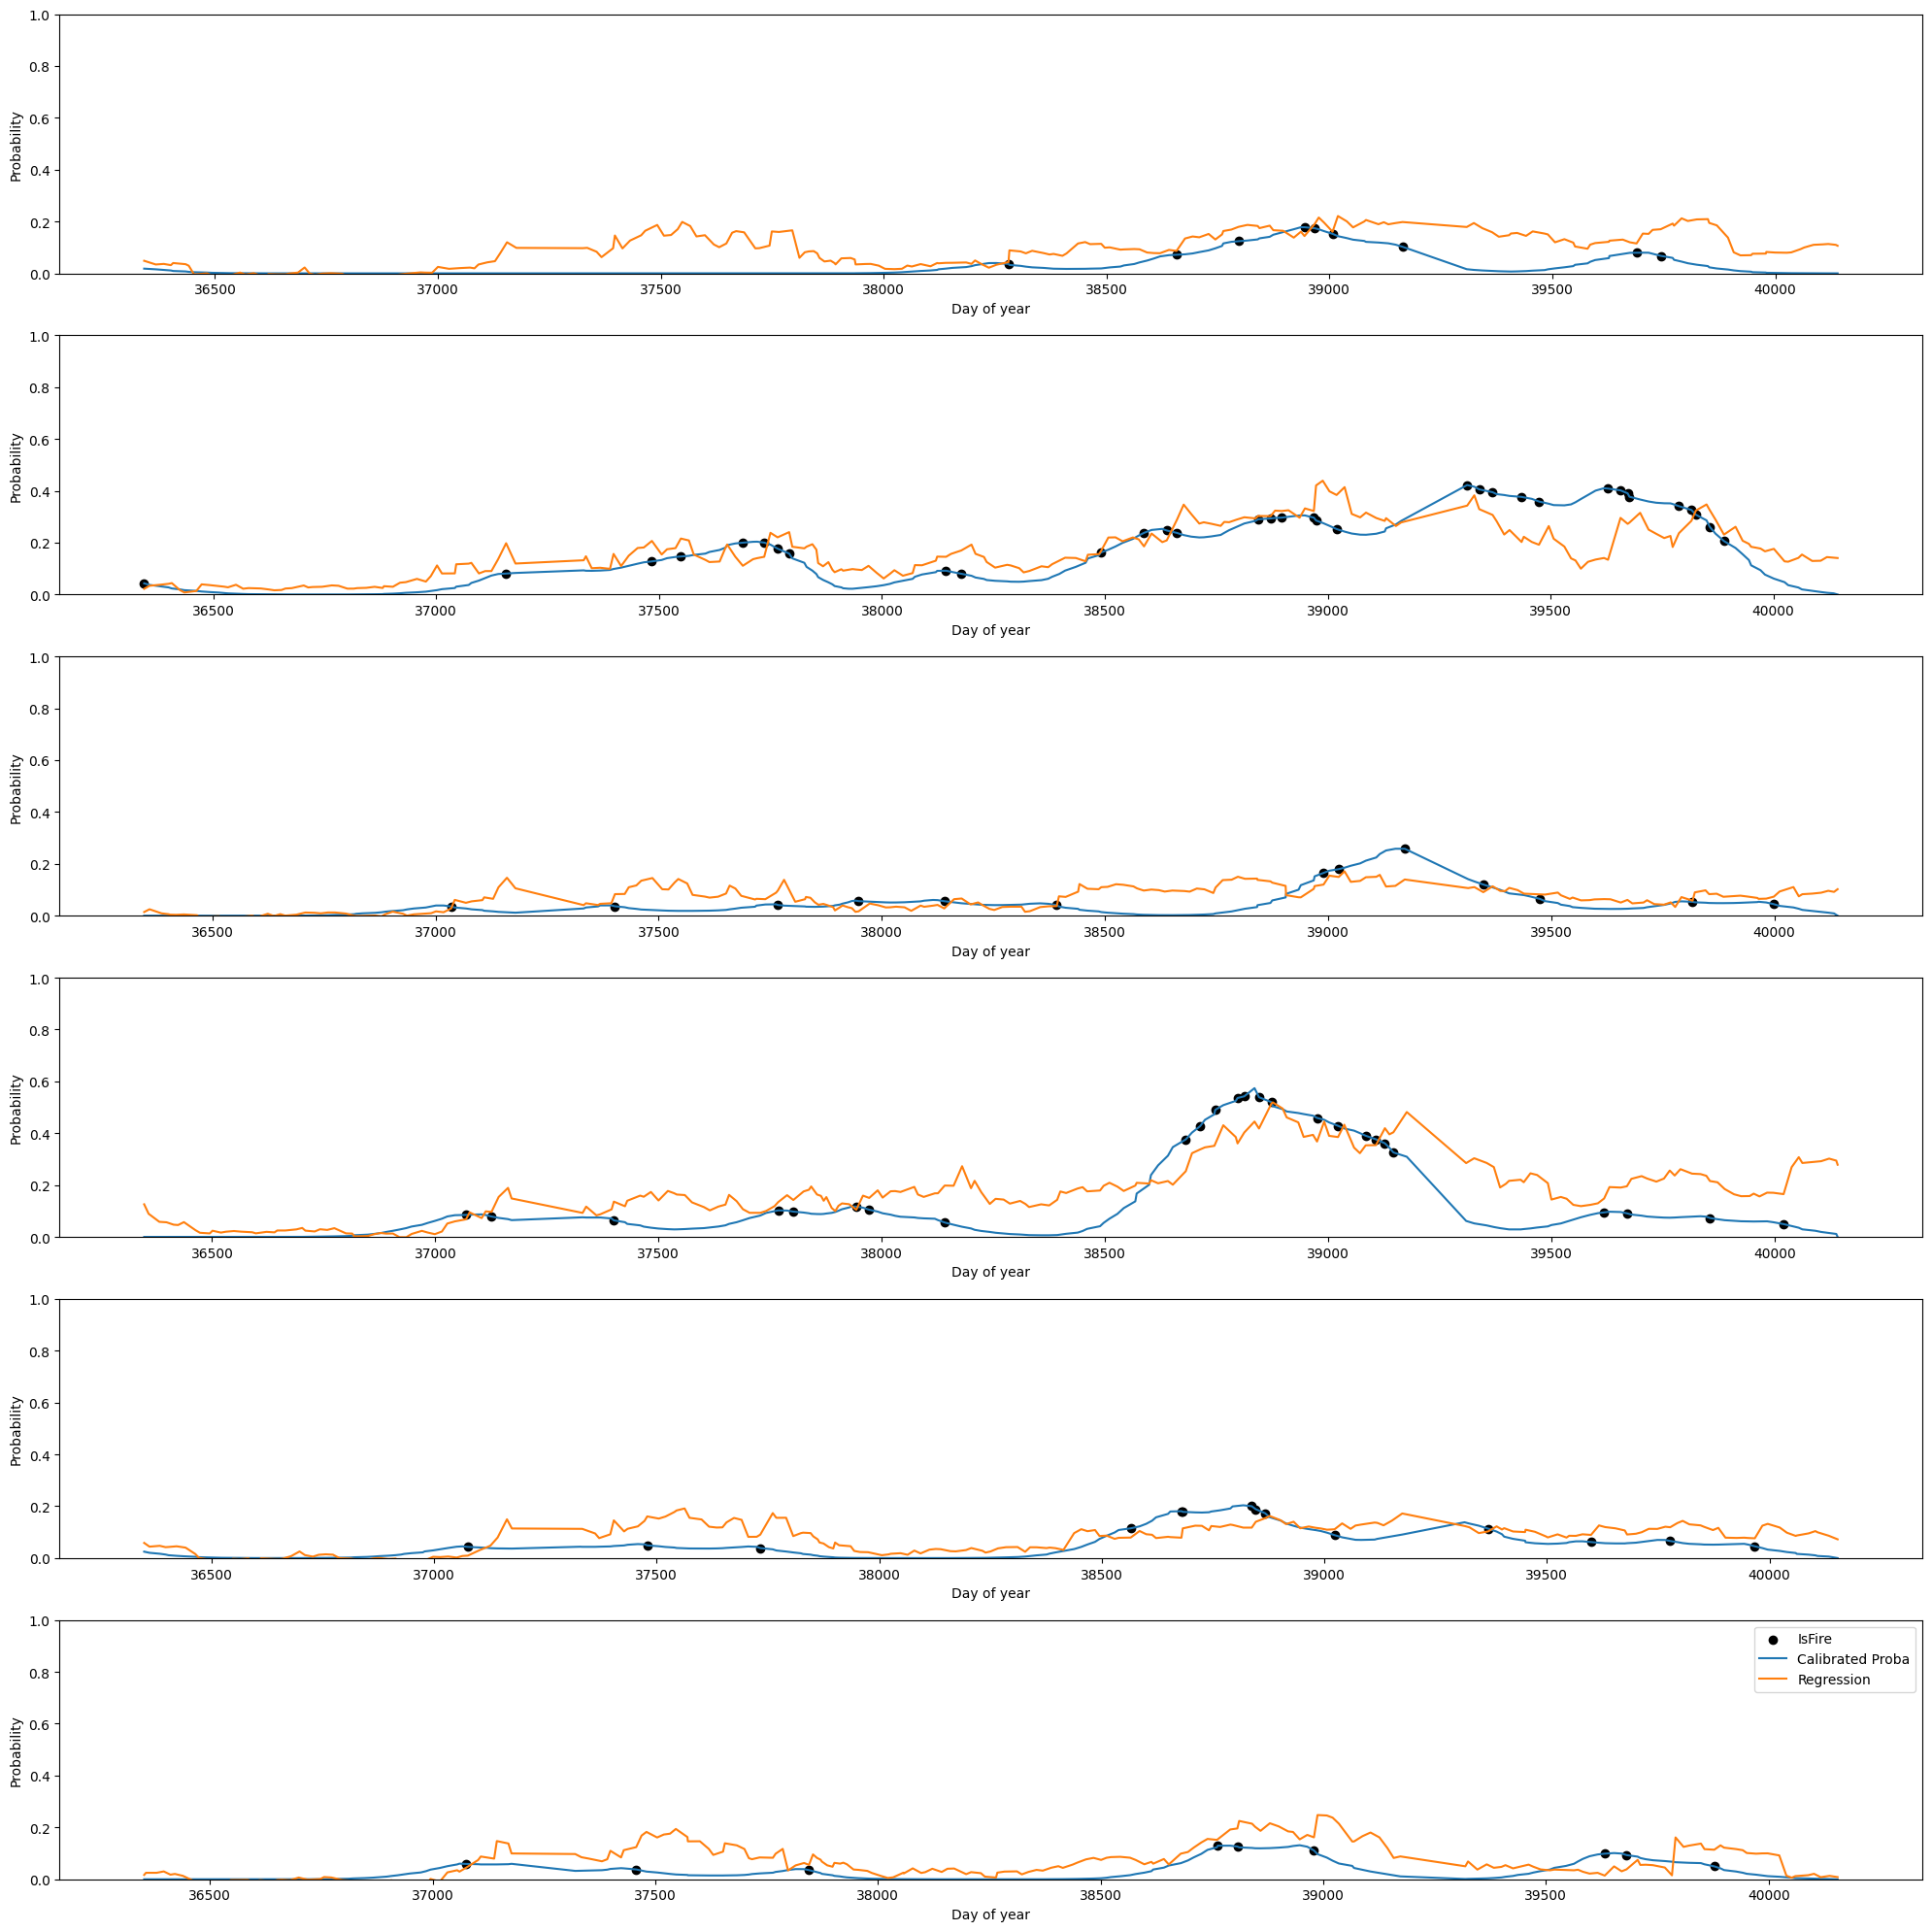

In [26]:
plot(dataset2023[dataset2023['cluster'].isin(Doubs)], subDir, 'doubs')

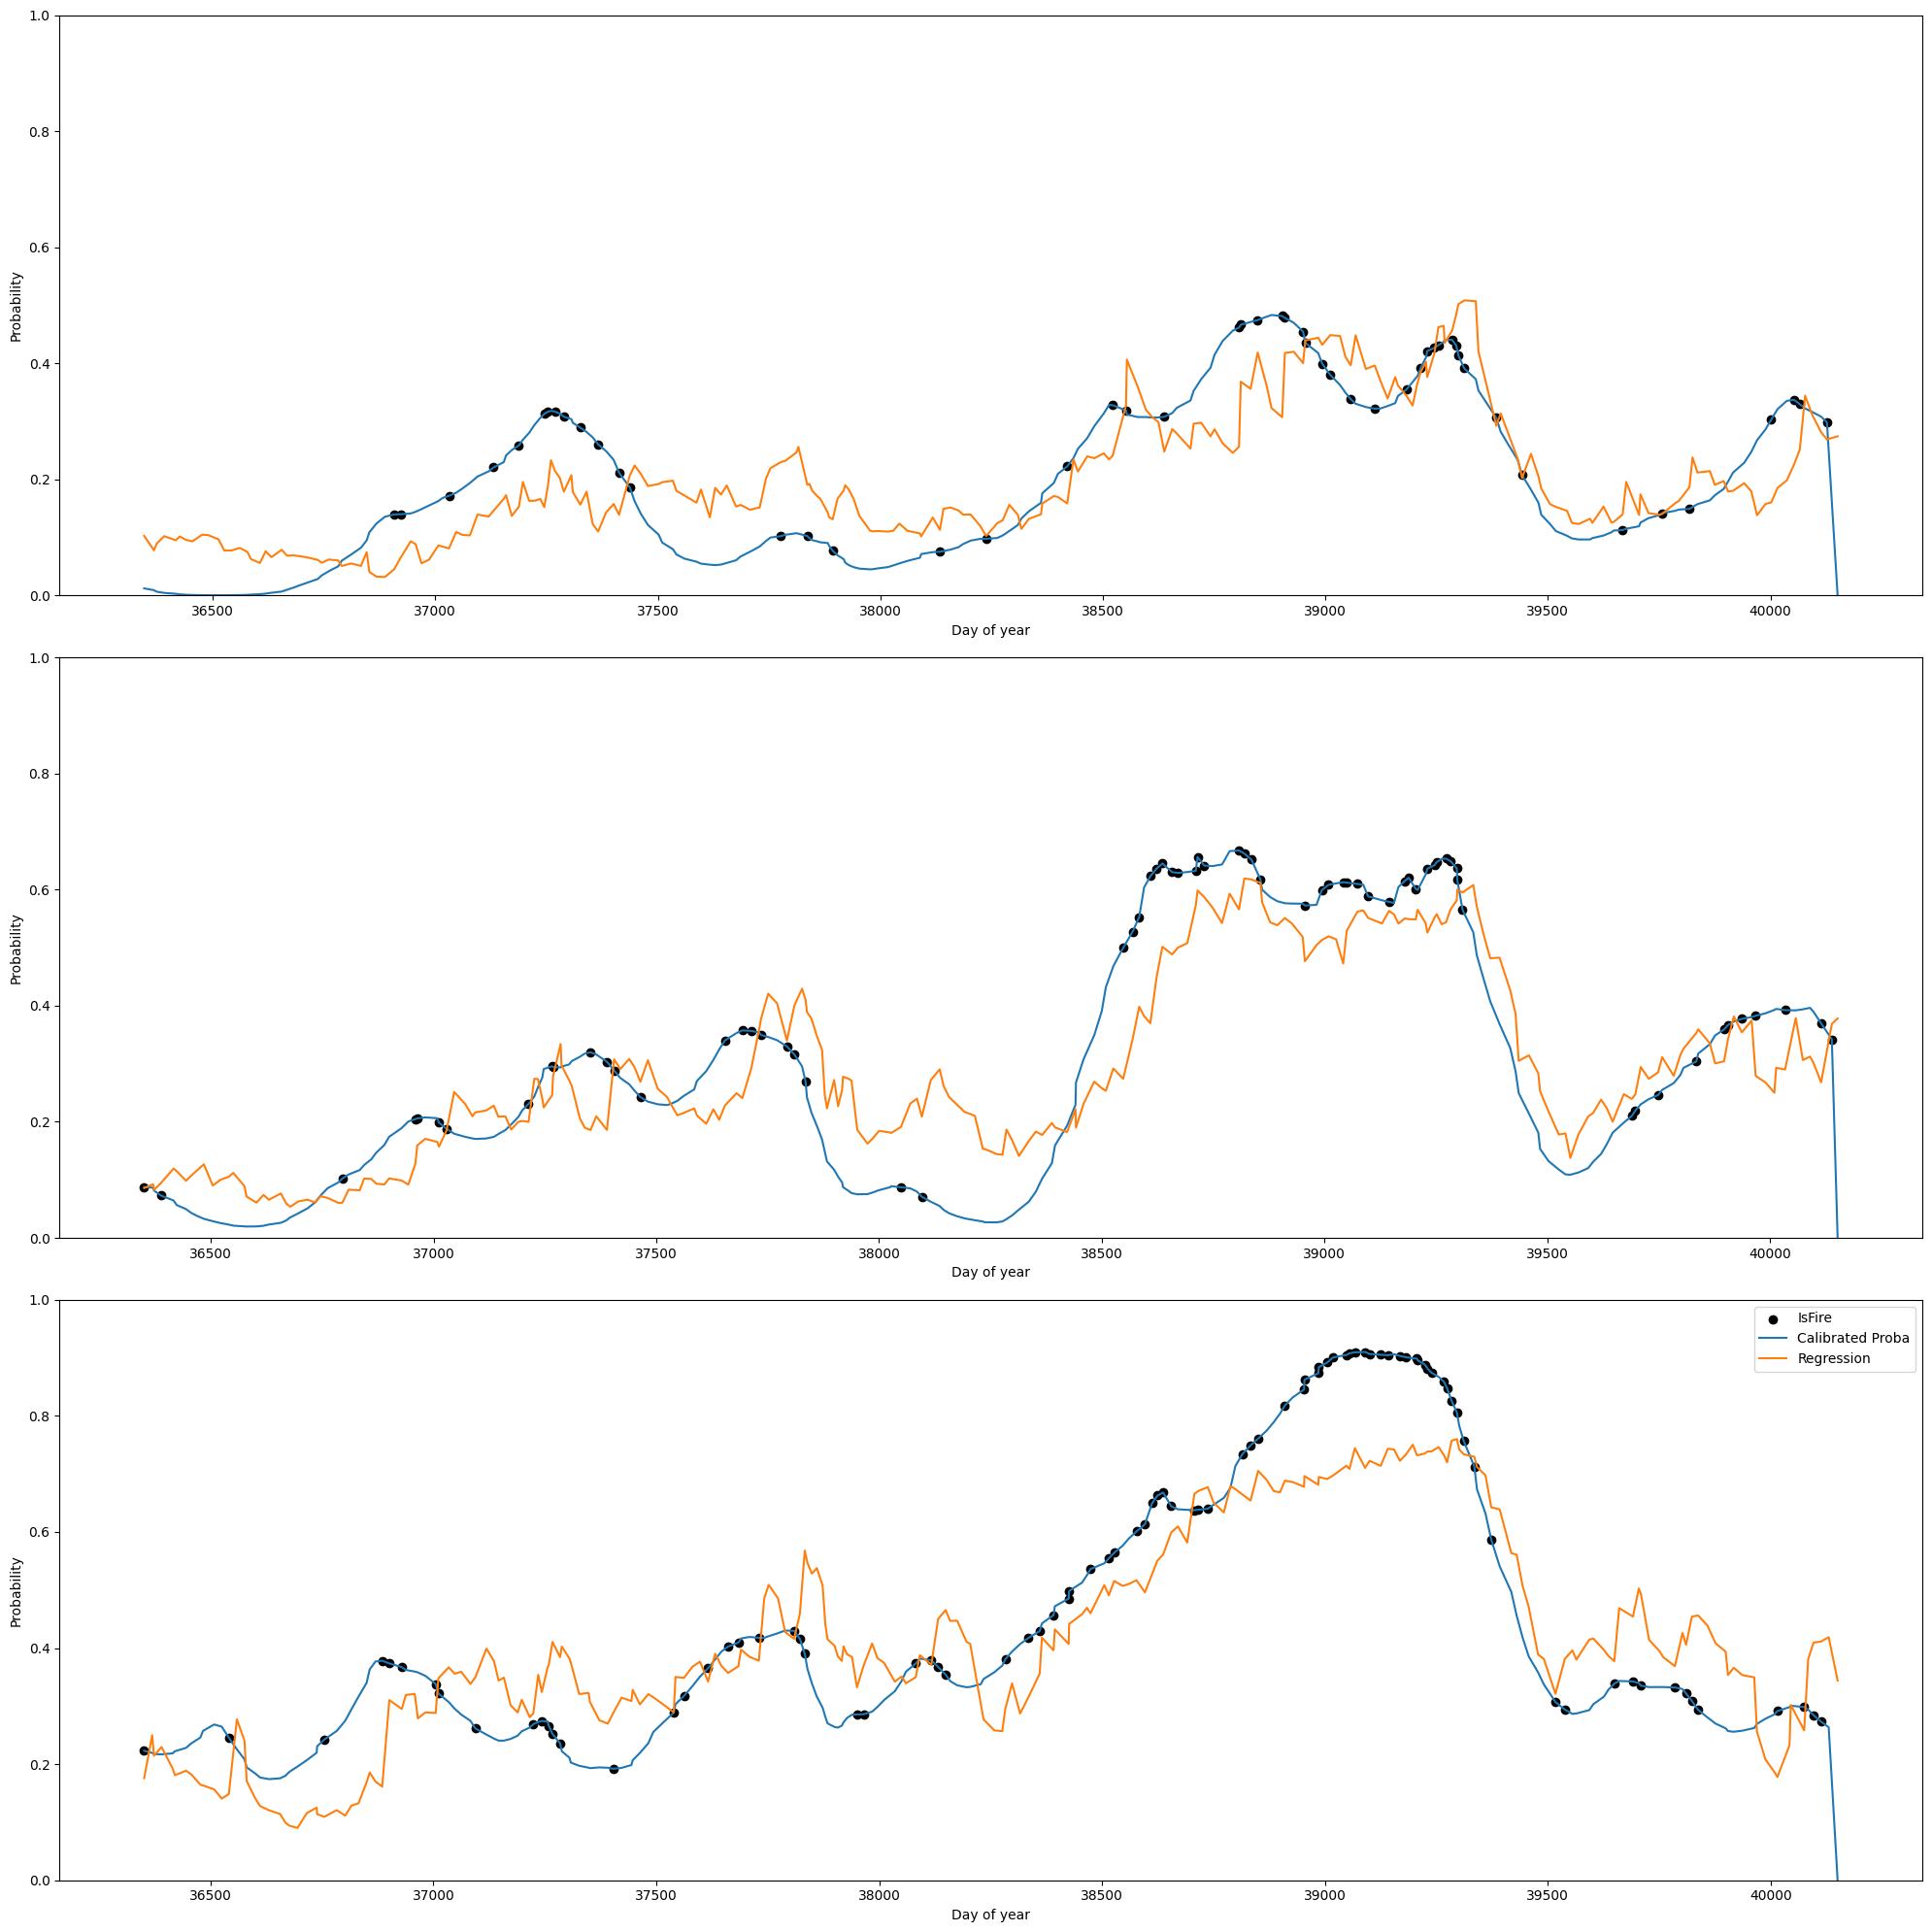

In [27]:
plot(dataset2023[dataset2023['cluster'].isin(Yvelines)], subDir, 'yvelines')

### Mapping

In [28]:
def get_latitude(x):
    return float(x.centroid.y)

def get_longitude(x):
    return float(x.centroid.x)

In [29]:
import geopandas as gpd
import pickle

departements = ['departement-01-ain', 'departement-25-doubs', 'departement-78-yvelines']

hexagones = []
clustersDF = []
firepoint = []

for dept in departements:
    cluster = pickle.load(open('../../csv/' + dept + '/temporal/dataset/clustersGM.pkl', 'rb'))
    dfc = pd.read_csv('../../csv/' + dept + '/temporal/dataset/clustersGM.csv')
    hexagone = gpd.read_file('../../csv/' + dept + '/data/geo/hexagones.geojson')
    fp = pd.read_csv('../../csv/' + dept + '/firepoint/NATURELSfire.csv')
    fp = gpd.GeoDataFrame(fp, geometry=gpd.points_from_xy(fp.longitude, fp.latitude))
    fp['departement'] = dept
    firepoint.append(fp)
    hexagone['departement'] = dept
    hexagone['latitude'] = hexagone['geometry'].apply(get_latitude)
    hexagone['longitude'] = hexagone['geometry'].apply(get_longitude)
    X = list(zip(hexagone['latitude'].values, hexagone['longitude'].values))
    hexagone['cluster'] = cluster.predict(X)
    hexagone['cluster'] = (int(dept.split('-')[1]) - 1) * 10 + hexagone['cluster']
    dfc['cluster'] = (int(dept.split('-')[1]) - 1) * 10 + dfc['cluster']
    clustersDF.append(dfc)
    hexagones.append(hexagone)

hexagones = pd.concat(hexagones).reset_index(drop=True)
clustersDF = pd.concat(clustersDF).reset_index(drop=True)
firepoint = pd.concat(firepoint).reset_index(drop=True)

In [30]:
dataset2023 = dataset2023[dataset2023['creneau'] >= '2023-06-01']

In [31]:
dataset2023[dataset2023['predictedProba_mid'] == dataset2023['predictedProba_mid'].max()]

,creneau,cluster,temp_std_0,dwpt_std_0,rhum_std_0,prcp_std_0,wdir_std_0,wspd_std_0,prec24h_std_0,dc_std_0,...,calibratedProbaNATURELSFiretest_7,calibratedClassNATURELSFiretest_7,calibratedProbaNATURELSFiretest_8,calibratedClassNATURELSFiretest_8,calibratedProbaNATURELSFiretest_9,calibratedClassNATURELSFiretest_9,calibratedProbaNATURELSFiretest_10,calibratedClassNATURELSFiretest_10,pred,predictedProba_mid
39296,2023-07-19,771,0.718427,0.913882,4.926317,0.0,4.625288,0.266222,0.0,34.741441,...,0.586735,4.0,0.540691,3.0,0.496738,3.0,0.45588,3.0,0.0,0.760114


In [32]:
dataset2023[dataset2023['nbNATURELSFire'] > 0]['nbNATURELSFire']

38588    1.0
38592    1.0
38596    1.0
38609    2.0
38612    1.0
        ... 
40139    2.0
40143    1.0
40145    1.0
40147    1.0
40148    2.0
Name: nbNATURELSFire, Length: 372, dtype: float64

In [33]:
prout = []

for j, testDay in enumerate(dataset2023.creneau.unique()):
    #fig, ax = plt.subplots(len(departements), 2, figsize=(15,15))
    print(testDay)
    testdataset = dataset2023[dataset2023['creneau'] == testDay]
    testFirepoint = firepoint[firepoint['date'] == testDay]

    hexagones['pred'] = 0.0
    hexagones['proba'] = 0.0

    clustersDF['pred'] = 0.0
    clustersDF['proba'] = 0.0
    clustersDF['nbNATURELSFire'] = 0.0

    for cluster in testdataset.cluster.unique():
        #hexagones.loc[hexagones[hexagones['cluster'] == cluster].index, 'pred'] = testdataset[testdataset['cluster'] == cluster]['predictedProba_mid'].values[0]
        #hexagones.loc[hexagones[hexagones['cluster'] == cluster].index, 'proba'] = testdataset[testdataset['cluster'] == cluster]['calibratedProbaNATURELSFiretest'].values[0]
        clustersDF.loc[clustersDF[clustersDF['cluster'] == cluster].index, 'pred'] = testdataset[testdataset['cluster'] == cluster]['predictedProba_mid'].values[0]
        clustersDF.loc[clustersDF[clustersDF['cluster'] == cluster].index, 'proba'] = testdataset[testdataset['cluster'] == cluster]['calibratedProbaNATURELSFiretest'].values[0]
        clustersDF.loc[clustersDF[clustersDF['cluster'] == cluster].index, 'nbNATURELSFire'] = testdataset[testdataset['cluster'] == cluster]['nbNATURELSFire'].values[0]
        #hexagones.loc[hexagones[hexagones['cluster'] == cluster].index, 'nbNATURELSFire'] = testdataset[testdataset['cluster'] == cluster]['nbNATURELSFire'].values[0]
    
    clustersDF['creneau'] = testDay
    prout.append(clustersDF.copy(deep=True))
    
    """for i, departement in enumerate(departements):
        hexagones[hexagones['departement'] == departement].plot(ax=ax[i][0], column='pred', vmin=0, vmax=1, cmap='jet')
        hexagones[hexagones['departement'] == departement].plot(ax=ax[i][1], column='proba', vmin=0, vmax=1, cmap='jet')
        #hexagones[hexagones['departement'] == departement].plot(ax=ax[i][2], column='interpolate_pred', vmin=0, vmax=1, cmap='jet')
        #hexagones[hexagones['departement'] == departement].plot(ax=ax[i][3], column='interpolate_proba', vmin=0, vmax=1, cmap='jet')
        testFirepoint[testFirepoint['departement'] == departement].plot(ax=ax[i][0], color='white')
        testFirepoint[testFirepoint['departement'] == departement].plot(ax=ax[i][1], color='white')"""
        
    """outname = ''
    outname +=  testDay+'.png'

    prout.append(hexagones)

    plt.savefig(dataset_version + '/output/' + outname)
    plt.close('all')"""

prout = pd.concat(prout).reset_index()

2023-06-01
2023-06-02
2023-06-03
2023-06-04
2023-06-05
2023-06-06
2023-06-07
2023-06-08
2023-06-09
2023-06-10
2023-06-11
2023-06-12
2023-06-13
2023-06-14
2023-06-15
2023-06-16
2023-06-17
2023-06-18
2023-06-19
2023-06-20
2023-06-21
2023-06-22
2023-06-23
2023-06-24
2023-06-25
2023-06-26
2023-06-27
2023-06-28
2023-06-29
2023-06-30
2023-07-01
2023-07-02
2023-07-03
2023-07-04
2023-07-05
2023-07-06
2023-07-07
2023-07-08
2023-07-09
2023-07-10
2023-07-11
2023-07-12
2023-07-13
2023-07-14
2023-07-15
2023-07-16
2023-07-17
2023-07-18
2023-07-19
2023-07-20
2023-07-21
2023-07-22
2023-07-23
2023-07-24
2023-07-25
2023-07-26
2023-07-27
2023-07-28
2023-07-29
2023-07-30
2023-07-31
2023-08-01
2023-08-02
2023-08-03
2023-08-04
2023-08-05
2023-08-06
2023-08-07
2023-08-08
2023-08-09
2023-08-10
2023-08-11
2023-08-12
2023-08-13
2023-08-14
2023-08-15
2023-08-16
2023-08-17
2023-08-18
2023-08-19
2023-08-20
2023-08-21
2023-08-22
2023-08-23
2023-08-24
2023-08-25
2023-08-26
2023-08-27
2023-08-28
2023-08-29
2023-08-30

In [34]:
#gbp = gpd.GeoDataFrame(prout.groupby('geometry')[['pred', 'nbNATURELSFire']].mean().reset_index())

In [35]:
gbp['erreur'] = abs(gbp['nbNATURELSFire'] - gbp['pred'])

NameError: name 'gbp' is not defined

In [ ]:
gbp['nbNATURELSFire'].plot()
gbp['pred'].plot()

NameError: name 'gbp' is not defined